In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sys import getsizeof
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split, Subset
from sklearn.preprocessing import LabelEncoder
from IPython.display import clear_output
import os
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from models import runANN
from data_loader import * 
from data_format import *
from datapath import *
from IPython.display import clear_output
import scipy.signal
import pywt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numpy import inf
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from IPython.display import clear_output
#os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:18230"


Using device: cuda
Using device: cuda


## setup preprocessing methods

In [3]:
# Sobel filter
def apply_sobel(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    sobel = cv2.magnitude(sobelx, sobely)
    return cv2.convertScaleAbs(sobel)

# Canny edge detector
def apply_canny(image, threshold1=0, threshold2=20):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    edges = cv2.Canny(gray, threshold1, threshold2)
    return edges

# Laplacian filter
def apply_laplacian(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    laplacian = cv2.Laplacian(gray, cv2.CV_64F)
    return cv2.convertScaleAbs(laplacian)

# Prewitt filter
def apply_prewitt(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    kernelx = np.array([[1, 0, -1], [1, 0, -1], [1, 0, -1]], dtype=np.float32)
    kernely = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]], dtype=np.float32)
    prewittx = cv2.filter2D(gray, -1, kernelx).astype(np.float32)
    prewitty = cv2.filter2D(gray, -1, kernely).astype(np.float32)
    prewitt = cv2.magnitude(prewittx, prewitty)
    return cv2.convertScaleAbs(prewitt)

# Scharr filter
def apply_schar(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    scharrx = cv2.Scharr(gray, cv2.CV_64F, 1, 0)
    scharry = cv2.Scharr(gray, cv2.CV_64F, 0, 1)
    scharr = cv2.magnitude(scharrx, scharry)
    return cv2.convertScaleAbs(scharr)

# Bilateral filter
def apply_bilateral(image, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

# Non-local means denoising
def apply_non_local_means(image, h=10, templateWindowSize=7, searchWindowSize=21):
    if len(image.shape)>=3:
        gray=image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    im=cv2.fastNlMeansDenoisingColored(gray, None, h, h, templateWindowSize, searchWindowSize)
    return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Guided filter (using OpenCV's guidedFilter)
def apply_guided_filter(image, radius=8, eps=0.01):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    guided = cv2.ximgproc.guidedFilter(gray, gray, radius, eps)
    return guided

"""# Optical flow (Farneback method)
def apply_optic_flow(prev_image, next_image):
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)
    next_gray = cv2.cvtColor(next_image, cv2.COLOR_BGR2GRAY)
    flow = cv2.calcOpticalFlowFarneback(prev_gray, next_gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    return flow"""

# Gaussian noise addition
def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Salt and pepper noise
def add_salt_and_pepper_noise(image, prob=0.02):
    noisy = image.copy()
    num_pixels = int(prob * image.size)
    coords = [np.random.randint(0, i - 1, num_pixels) for i in image.shape]
    noisy[coords[0], coords[1]] = 255  # Salt
    coords = [np.random.randint(0, i - 1, num_pixels) for i in image.shape]
    noisy[coords[0], coords[1]] = 0  # Pepper
    return noisy

# Speckle noise
def add_speckle_noise(image, std=0.1):
    noise = np.random.randn(*image.shape) * std
    noisy_image = image + image * noise
    return np.clip(noisy_image, 0, 255).astype(np.uint8)

# Poisson noise
def add_poisson_noise(image):
    noisy = np.random.poisson(image).astype(np.uint8)
    return noisy

# Median filtering
def apply_median_filter(image, ksize=5):
    return cv2.medianBlur(image, ksize)

# Gaussian blur
def apply_gaussian_blur(image, ksize=5, sigma=1):
    return cv2.GaussianBlur(image, (ksize, ksize), sigma)

# Wiener filter
def apply_wiener_filter(image, kernel_size=5):
    return scipy.signal.wiener(image, (kernel_size, kernel_size))

# Wavelet denoising
def apply_wavelet_denoising(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    coeffs = pywt.wavedec2(image.astype(np.float32), 'db1', level=1)
    return np.clip(pywt.waverec2(coeffs, 'db1'), 0, 255).astype(np.uint8)

# Histogram equalization
def apply_histogram_equalization(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    return cv2.equalizeHist(gray)

# Adaptive histogram equalization
def apply_adaptive_histogram_equalization(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    return clahe.apply(gray)

# Gamma correction
def apply_gamma_correction(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in np.arange(0, 256)]).astype(np.uint8)
    return cv2.LUT(image, table)

# Top-hat and black-hat transformations
def apply_tophat_blackhat(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    tophat = cv2.morphologyEx(gray, cv2.MORPH_TOPHAT, kernel)
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    return blackhat

# Unsharp masking
def apply_unsharp_masking(image, alpha=1.5, beta=-0.5):
    blurred = cv2.GaussianBlur(image, (0, 0), 5)
    return cv2.addWeighted(image, alpha, blurred, beta, 0)

# Retinex algorithm (using MultiScale Retinex)
def apply_retinex(image, sigma_list=[15, 80, 250]):
    retinex = np.zeros_like(image, dtype=np.float32)
    for sigma in sigma_list:
        blur = cv2.GaussianBlur(image, (0, 0), sigma)
        retinex += np.log1p(image) - np.log1p(blur)
    return cv2.normalize(retinex, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Log transformation
def apply_log_transform(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    return cv2.normalize(np.log1p(image.astype(np.float32)), None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

# Power-law transformation
def apply_power_law_transform(image, gamma=1.0):
    return np.array(255 * (image / 255) ** gamma, dtype=np.uint8)

# Fourier transform
def apply_fourier_transform(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    dft = np.fft.fft2(gray)
    dft_shift = np.fft.fftshift(dft)
    magnitude_spectrum = 20 * np.log(np.abs(dft_shift)+1e-8)
    return magnitude_spectrum.astype(np.uint8)

# Gabor filters
def apply_gabor_filter(image, ksize=41, sigma=6.0, lambd=5.0, gamma=0.9, psi=0):
    theta = np.pi / 4
    gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, psi, ktype=cv2.CV_32F)
    return cv2.filter2D(image, cv2.CV_8UC3, gabor_kernel)

# Haar wavelet transform
def apply_haar_wavelet(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    coeffs2 = pywt.dwt2(gray, 'haar')
    cA, (cH, cV, cD) = coeffs2
    im=cA.astype(np.uint8)
    return cv2.resize(im, gray.T.shape, interpolation = cv2.INTER_LINEAR)

# Gradient magnitude and orientation maps
def compute_gradient_magnitude_orientation(image):
    if len(image.shape)>=3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray=image
    grad_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = cv2.magnitude(grad_x, grad_y)
    orientation = np.arctan2(grad_y, grad_x)
    return orientation

In [4]:
def apply_to_dataset(function):
    data=loaded(10)
    for i in range(data.X.shape[0]):
        for t in range(data.X.shape[1]):
            image=data.X[i][t]
            image=function(image)
            data.X[i][t]=image.copy()
    return data
functions = [
    # Edge Detection & Filtering
    apply_sobel,
    apply_canny,
    apply_laplacian,
    apply_prewitt,
    apply_schar,
    apply_gabor_filter,
    compute_gradient_magnitude_orientation,

    # Denoising & Smoothing
    apply_bilateral,
    apply_non_local_means,
    apply_wiener_filter,
    apply_wavelet_denoising,
    apply_median_filter,
    apply_gaussian_blur,

    # Noise Addition
    add_gaussian_noise,
    add_salt_and_pepper_noise,
    add_speckle_noise,
    add_poisson_noise,

    # Contrast Enhancement & Transformations
    apply_histogram_equalization,
    apply_adaptive_histogram_equalization,
    apply_gamma_correction,
    apply_tophat_blackhat,
    apply_unsharp_masking,
    apply_retinex,
    apply_log_transform,
    apply_power_law_transform,

    # Transforms
    apply_fourier_transform,
    apply_haar_wavelet,

    # Guided Filtering & Special Processing
    apply_guided_filter
]
test_image=np.random.random((150,150,)).astype(np.uint8)
####### test that we can pass data through 
for func in functions:
    im=func(test_image.copy())
    assert test_image.shape==im.shape, str(test_image.shape)+" does not match "+str(im.shape)+" for "+str(func.__name__)

print("All",len(functions),"functions run")

/its/home/drs25/.local/lib/python3.10/site-packages/scipy/signal/_signaltools.py:1647: RuntimeWarning: invalid value encountered in divide
  res *= (1 - noise / lVar)


All 28 functions run


### show image examples

Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB


<Figure size 1200x1925 with 0 Axes>

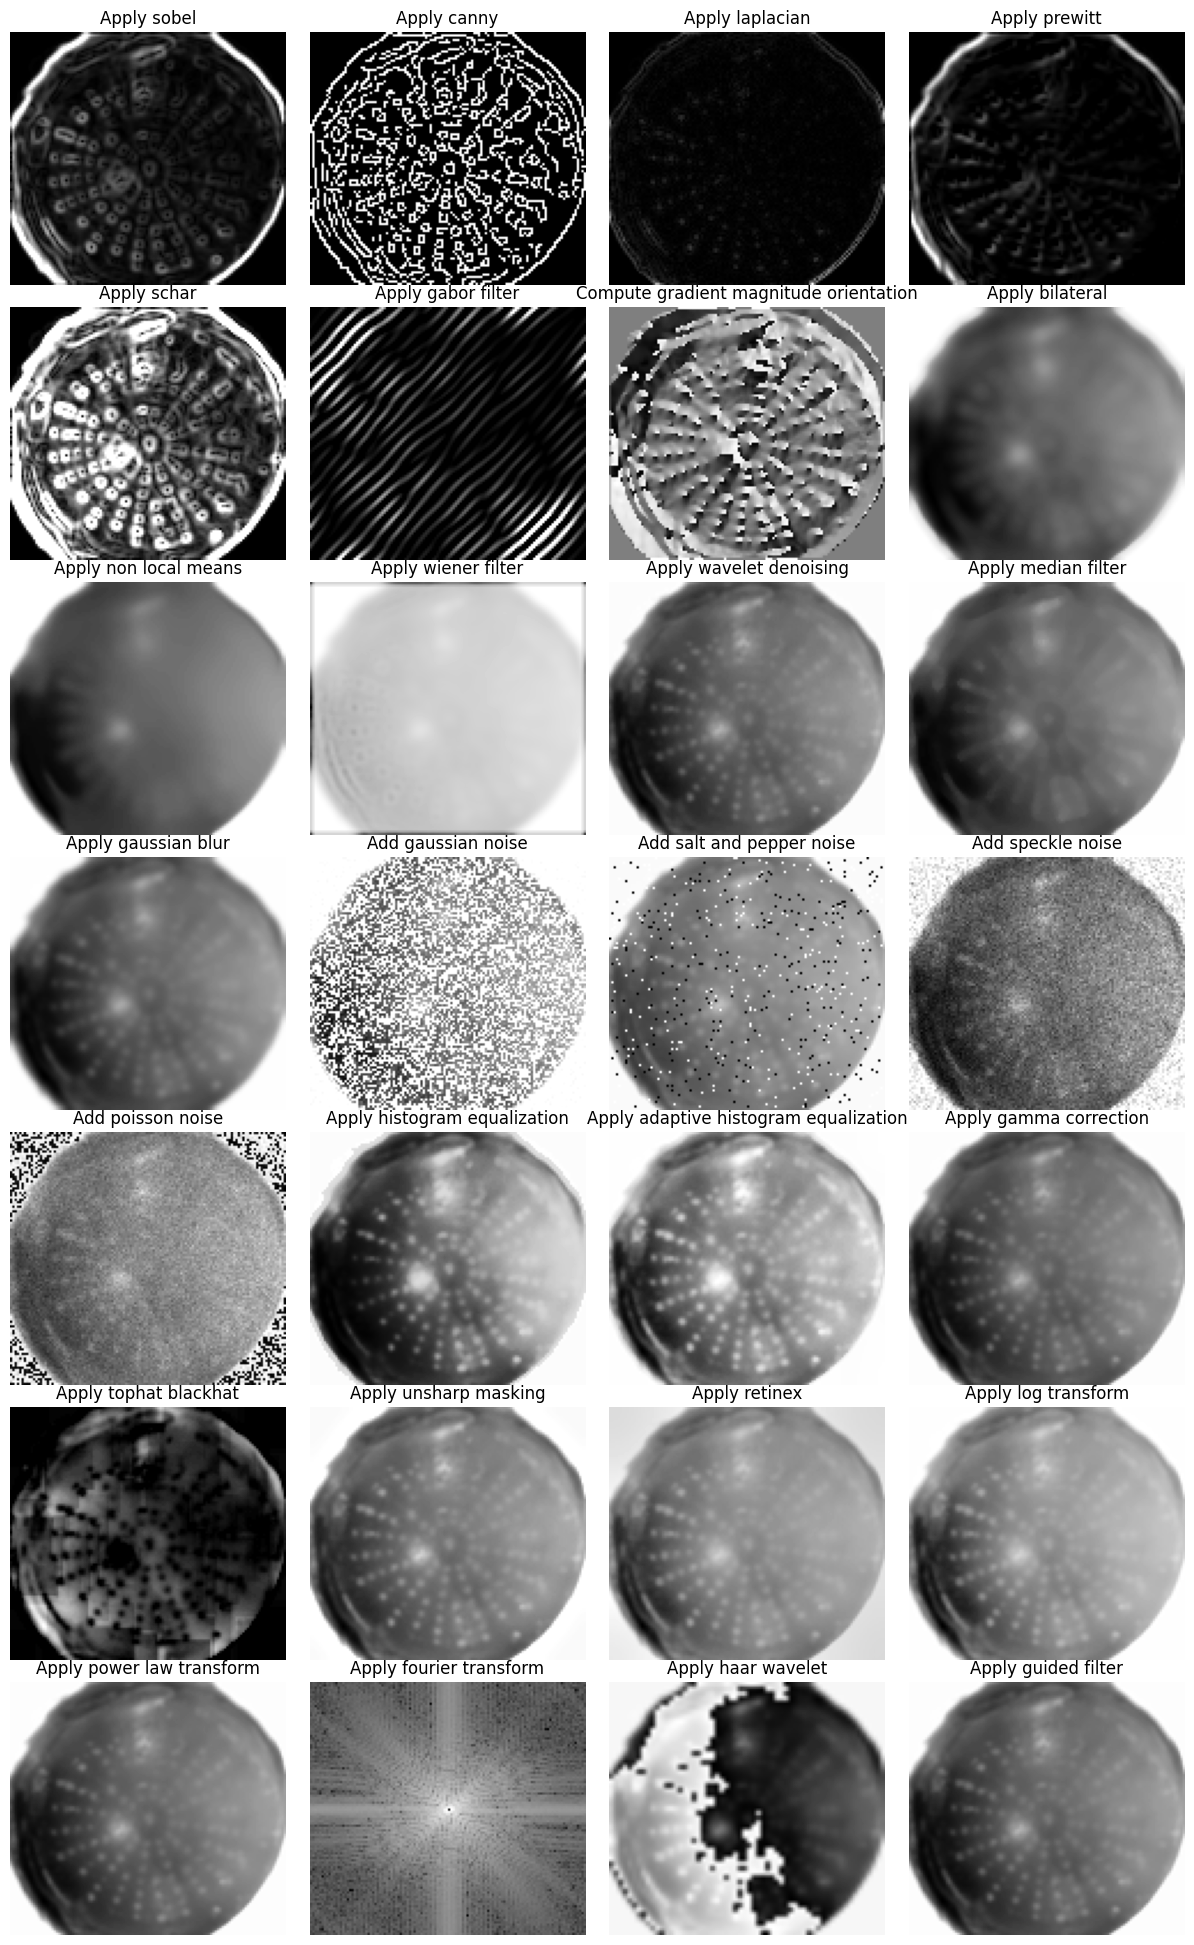

In [86]:
data=loaded(4)
example_image = data.X[0][2]
n = len(functions)
cols = 4  # Number of columns
rows = (n // cols) + (n % cols > 0)  # Compute rows dynamically

# Determine image aspect ratio for correct figure size
img_h, img_w = example_image.shape[:2]
figsize_scale = 3  # Adjust for readability
fig = plt.figure(figsize=(cols * figsize_scale, rows * (figsize_scale * (img_h / img_w))))

# Create subplots with no spacing
fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_scale, rows * (figsize_scale * (img_h / img_w))))
axes = axes.flatten()  # Flatten for easy iteration

results = []
names = []

# Loop over functions and apply them
for i, func in enumerate(functions):
    try:
        new_image = func(example_image.copy())  # Apply function

        # Show the transformed image
        axes[i].imshow(new_image, cmap='gray', aspect='equal')
        results.append(new_image)

        # Format function name
        name = func.__name__.replace("_", " ").capitalize()
        names.append(name)

        # Set title and remove axes
        axes[i].set_title(name, fontsize=12)
        axes[i].axis('off')
        axes[i].set_adjustable('box')  # Ensure aspect ratio stays correct
    except Exception as e:
        # Display error message if function fails
        axes[i].text(0.5, 0.5, f"Error\n{str(e)}", ha='center', va='center', fontsize=8)
        axes[i].set_title(func.__name__, fontsize=12)
        axes[i].axis('off')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove empty subplots

# Adjust layout to remove white space
plt.subplots_adjust(wspace=0, hspace=0)  # No gaps between subplots
plt.margins(0)  # Remove margins
plt.tight_layout(pad=0)  # No padding around figure

# Save without excess borders
plt.savefig(path + "/images/filter_examples.pdf", bbox_inches='tight', pad_inches=0)
plt.show()


## setup metric for evaluating numerically where the dataset stands

/tmp/ipykernel_3714881/840467184.py:70: RuntimeWarning: overflow encountered in scalar add
  michelson_original = (I_max_orig - I_min_orig) / (I_max_orig + I_min_orig + 1e-6)
/tmp/ipykernel_3714881/840467184.py:71: RuntimeWarning: overflow encountered in scalar add
  michelson_processed = (I_max_proc - I_min_proc) / (I_max_proc + I_min_proc + 1e-6)
/its/home/drs25/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


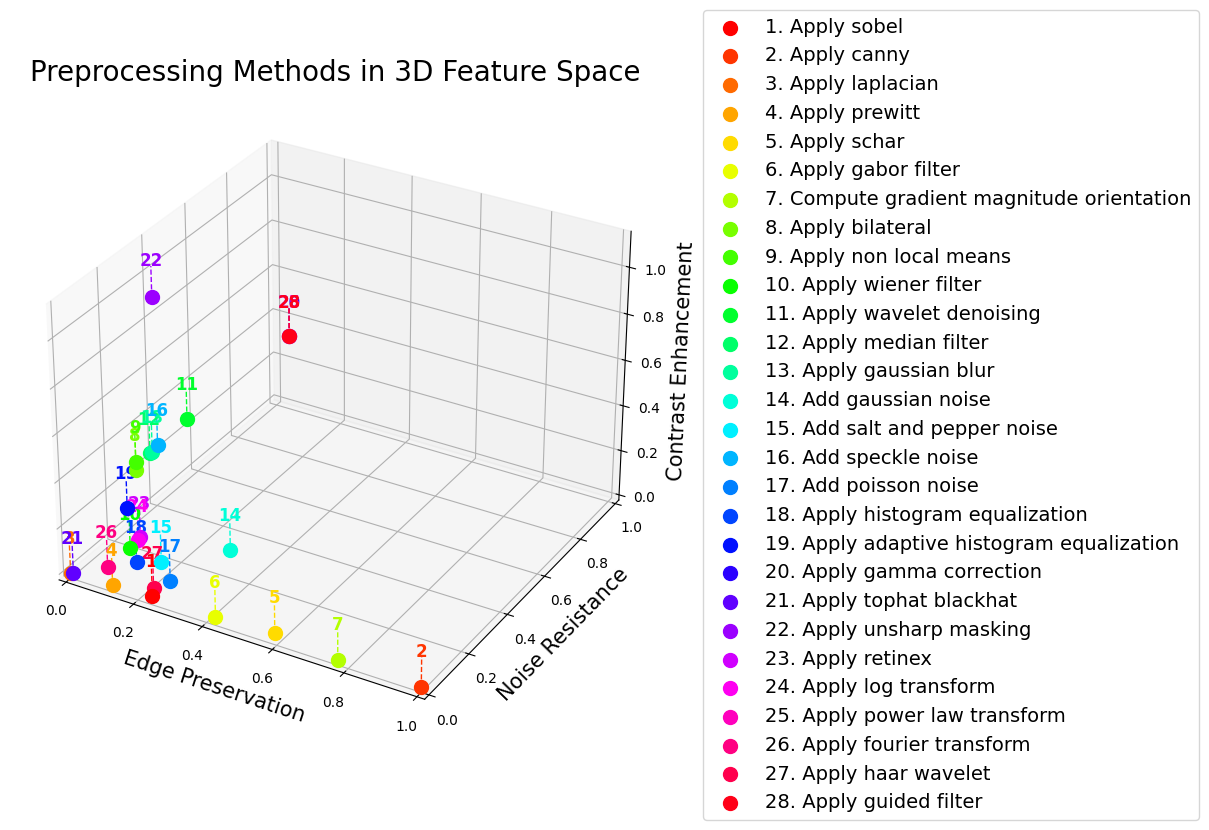

In [91]:
import cv2
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio as psnr

def edge_preservation_index(original, processed):
    """Computes the Edge Preservation Index (EPI) between original and processed images.
    
    EPI is calculated using the ratio of edge magnitudes between the processed and original images.
    
    Returns:
        float: Edge Preservation Index (higher means better edge retention).
    """
    # Convert to grayscale if needed
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    if len(processed.shape) == 3:
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
    
    # Compute edge maps using Sobel filter
    sobel_x_orig = cv2.Sobel(original, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y_orig = cv2.Sobel(original, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag_orig = np.sqrt(sobel_x_orig**2 + sobel_y_orig**2)

    sobel_x_proc = cv2.Sobel(processed, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y_proc = cv2.Sobel(processed, cv2.CV_64F, 0, 1, ksize=3)
    edge_mag_proc = np.sqrt(sobel_x_proc**2 + sobel_y_proc**2)
    
    # Compute Edge Preservation Index (EPI)
    epi = np.sum(edge_mag_proc) / (np.sum(edge_mag_orig) + 1e-6)  # Avoid division by zero
    
    return epi

def noise_sensitivity_score(original, processed):
    """Evaluates how much noise is retained or introduced by an image processing method.
    
    Uses:
    - Peak Signal-to-Noise Ratio (PSNR)
    """
    # Convert to grayscale if needed
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    if len(processed.shape) == 3:
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)


    psnr_value = np.array(psnr(original, processed, data_range=255))
    psnr_value[psnr_value==inf]=100.0
    # Apply log scaling: log(1 + PSNR) to avoid log(0)
    return psnr_value # log1p(x) = log(1 + x)

def contrast_enhancement_score(original, processed):
    """Measures contrast enhancement using:
    
    - Michelson Contrast
    - RMS Contrast
    - Histogram Spread
    """
    # Convert to grayscale if needed
    if len(original.shape) == 3:
        original = cv2.cvtColor(original, cv2.COLOR_BGR2GRAY)
    if len(processed.shape) == 3:
        processed = cv2.cvtColor(processed, cv2.COLOR_BGR2GRAY)
    
    # Michelson Contrast (Global Contrast)
    I_max_orig, I_min_orig = np.max(original), np.min(original)
    I_max_proc, I_min_proc = np.max(processed), np.min(processed)
    
    michelson_original = (I_max_orig - I_min_orig) / (I_max_orig + I_min_orig + 1e-6)
    michelson_processed = (I_max_proc - I_min_proc) / (I_max_proc + I_min_proc + 1e-6)
    michelson_change = michelson_processed - michelson_original

    # RMS Contrast (Local Contrast)
    rms_original = np.std(original)
    rms_processed = np.std(processed)
    rms_change = rms_processed - rms_original

    # Histogram Spread (Variance of Intensity Distribution)
    hist_spread_original = np.var(original)
    hist_spread_processed = np.var(processed)
    hist_spread_change = hist_spread_processed - hist_spread_original

    return michelson_change

def normalize(value, min_val, max_val):
    """Scales a value to the range [0,1] using min-max normalization."""
    return (value - min_val) / (max_val - min_val + 1e-6)  # Avoid division by zero

def compute_3D_representation(original, processed):
    """Computes a 3D coordinate representing Edge Preservation, Noise Sensitivity, and Contrast Enhancement.

    """
    # Get metrics
    edge_metrics = edge_preservation_index(original, processed)
    noise_metrics = noise_sensitivity_score(original, processed)
    contrast_metrics = contrast_enhancement_score(original, processed)

    # Normalize values
    x = edge_metrics
    y = noise_metrics # Higher PSNR means less noise, so higher y is better
    z = contrast_metrics

    return (x, y, z)  # 3D coordinate


def plot_3D_results(results,labels):
    """Plots multiple preprocessing methods in 3D space with numbered labels in the legend and on the plot."""
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    # Generate unique colors using a colormap
    cmap = plt.get_cmap("hsv")  
    colors = [cmap(i) for i in np.linspace(0, 1, len(results))]

    # Assign numbers to each method
    numbered_labels = {method: i + 1 for i, method in enumerate(labels)}

    # Plot points first
    scatter_points = []
    for (method, coords), color in zip(zip(labels,results), colors):
        number = numbered_labels[method]  # Get the assigned number
        scatter = ax.scatter(*coords, label=f"{number}. {method}", s=100, color=color)
        scatter_points.append(scatter)  # Store scatter points

    # Plot numbers AFTER all points (ensuring they are on top) with connecting lines
    for (method, coords), color in zip(zip(labels,results), colors):
        number = numbered_labels[method]

        # Alternate text placement for clarity
        text_offset = np.std(results)/2 #if number % 2 == 0 else -0.6
        text_coords = (coords[0], coords[1], coords[2]+text_offset )

        # Draw a line from the point to the text
        ax.plot([coords[0], text_coords[0]], 
                [coords[1], text_coords[1]], 
                [coords[2], text_coords[2]], 
                color=color, linestyle="dashed", linewidth=1)

        # Add the text label
        ax.text(*text_coords, str(number), 
                fontsize=12, ha='center', color=color, fontweight='bold')

    # Label axes
    ax.set_xlabel("Edge Preservation",fontsize=15)
    ax.set_ylabel("Noise Resistance",fontsize=15)
    ax.set_zlabel("Contrast Enhancement",fontsize=15)
    ax.set_title("Preprocessing Methods in 3D Feature Space",fontsize=20)

    # Move the legend to the right of the figure
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fontsize=14)
    plt.subplots_adjust(wspace=0, hspace=0)  # No gaps between subplots
    plt.margins(0)  # Remove margins
    plt.tight_layout(pad=0)  # No padding around figure
    plt.savefig(path+"/images/3d-filters.pdf")
    plt.show()

processed=[]
labels=[]
for i,res in enumerate(results):
    val=compute_3D_representation(example_image.astype(np.uint8),res.astype(np.uint8))
    labels.append(names[i])
    processed.append(val)

#normalize
processed=np.array(processed)

processed[:,0]=(processed[:,0]-np.min(processed[:,0]))/(np.max(processed[:,0])-np.min(processed[:,0]))
processed[:,1]=(processed[:,1]-np.min(processed[:,1]))/(np.max(processed[:,1])-np.min(processed[:,1]))
processed[:,2]=(processed[:,2]-np.min(processed[:,2]))/(np.max(processed[:,2])-np.min(processed[:,2]))

plot_3D_results(processed,labels)


## evaluate performance of each method

In [7]:
def test_filter(filter):
    dataset=apply_to_dataset(filter)
    dataset.shuffle()
    train_loader,test_loader=org_data(dataset,(len(dataset.X),dataset.X.shape[1],dataset.X.shape[2]*dataset.X.shape[3]))
    model,history=runLSTM(train_loader,0,dataset.X.shape[1],num_epochs = 100)
    train=calc(model,train_loader)
    test=calc(model,test_loader)
    return train,test

acc=np.load(path+"/data/20_trials_28_filters_lstm.npy")
#acc=np.zeros((28,20,2))
for i in range(0,len(functions)):
    for trial in range(20):
        clear_output(wait=True)
        print(i,trial)
        train,test=test_filter(functions[i])
        acc[i][trial][0]=train
        acc[i][trial][1]=test
    np.save(path+"/data/20_trials_28_filters_lstm_",acc)

27 19
Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
LOADED DATASET...
Memory left 23.59 GB
(3000, 10, 110, 120) (3000, 10, 13200)
Using 2.95 GB
torch.Size([3000, 10, 13200])
torch.Size([3000, 15])


/its/home/drs25/RoboSkin/Code/NewRigExperiments/data_format.py:96: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels_tensor = torch.tensor(one_hot_labels, dtype=torch.float32).to(device)


Epoch [1/100], Step [60/60], Loss: 162.3881
Epoch [11/100], Step [60/60], Loss: 158.1300
Epoch [21/100], Step [60/60], Loss: 131.9151
Epoch [31/100], Step [60/60], Loss: 117.3261
Epoch [41/100], Step [60/60], Loss: 105.9169
Epoch [51/100], Step [60/60], Loss: 100.3957
Epoch [61/100], Step [60/60], Loss: 97.5545
Epoch [71/100], Step [60/60], Loss: 87.6963
Epoch [81/100], Step [60/60], Loss: 72.9258
Epoch [91/100], Step [60/60], Loss: 55.6640
Finished Training
Accuracy: 90.8712136994292 %
Accuracy: 88.98516913847692 %


### statistical analysis

In [18]:
#open up file
pd.set_option('display.width', 200)  # Adjust width
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', 50)  # Adjust to your preference


data=np.load(path+"/data/20_trials_28_filters_lstm.npy")
names=[str(func.__name__) for func in functions]
#convert to dataframe 

df = pd.DataFrame({
    "Class": np.repeat(names, 20),  # Use function names instead of numbers
    "Trial": np.tile(np.arange(20), len(names)),  # 20 trials per class
    "Train Accuracy": data[:, :, 0].flatten(),
    "Test Accuracy": data[:, :, 1].flatten()
})
# Compute summary statistics per class
summary = df.groupby("Class")[["Train Accuracy", "Test Accuracy"]].agg(["mean", "max", "min", "std"])
#show mean, min, max, std for each filter 
#print(summary)

print(summary)
#do the ranksum test on each

                                       Train Accuracy                               Test Accuracy                              
                                                 mean       max       min       std          mean       max       min       std
Class                                                                                                                          
add_gaussian_noise                           0.270114  0.345819  0.222907  0.034905      0.236711  0.343276  0.191635  0.036754
add_poisson_noise                            0.352839  0.441648  0.275405  0.053734      0.311115  0.424929  0.219963  0.055532
add_salt_and_pepper_noise                    0.426086  0.511229  0.346652  0.037623      0.388685  0.461590  0.301616  0.044382
add_speckle_noise                            0.579268  0.794550  0.475397  0.094077      0.548992  0.783203  0.421596  0.106803
apply_adaptive_histogram_equalization        0.801217  0.964126  0.604558  0.088743      0.786952  0.959

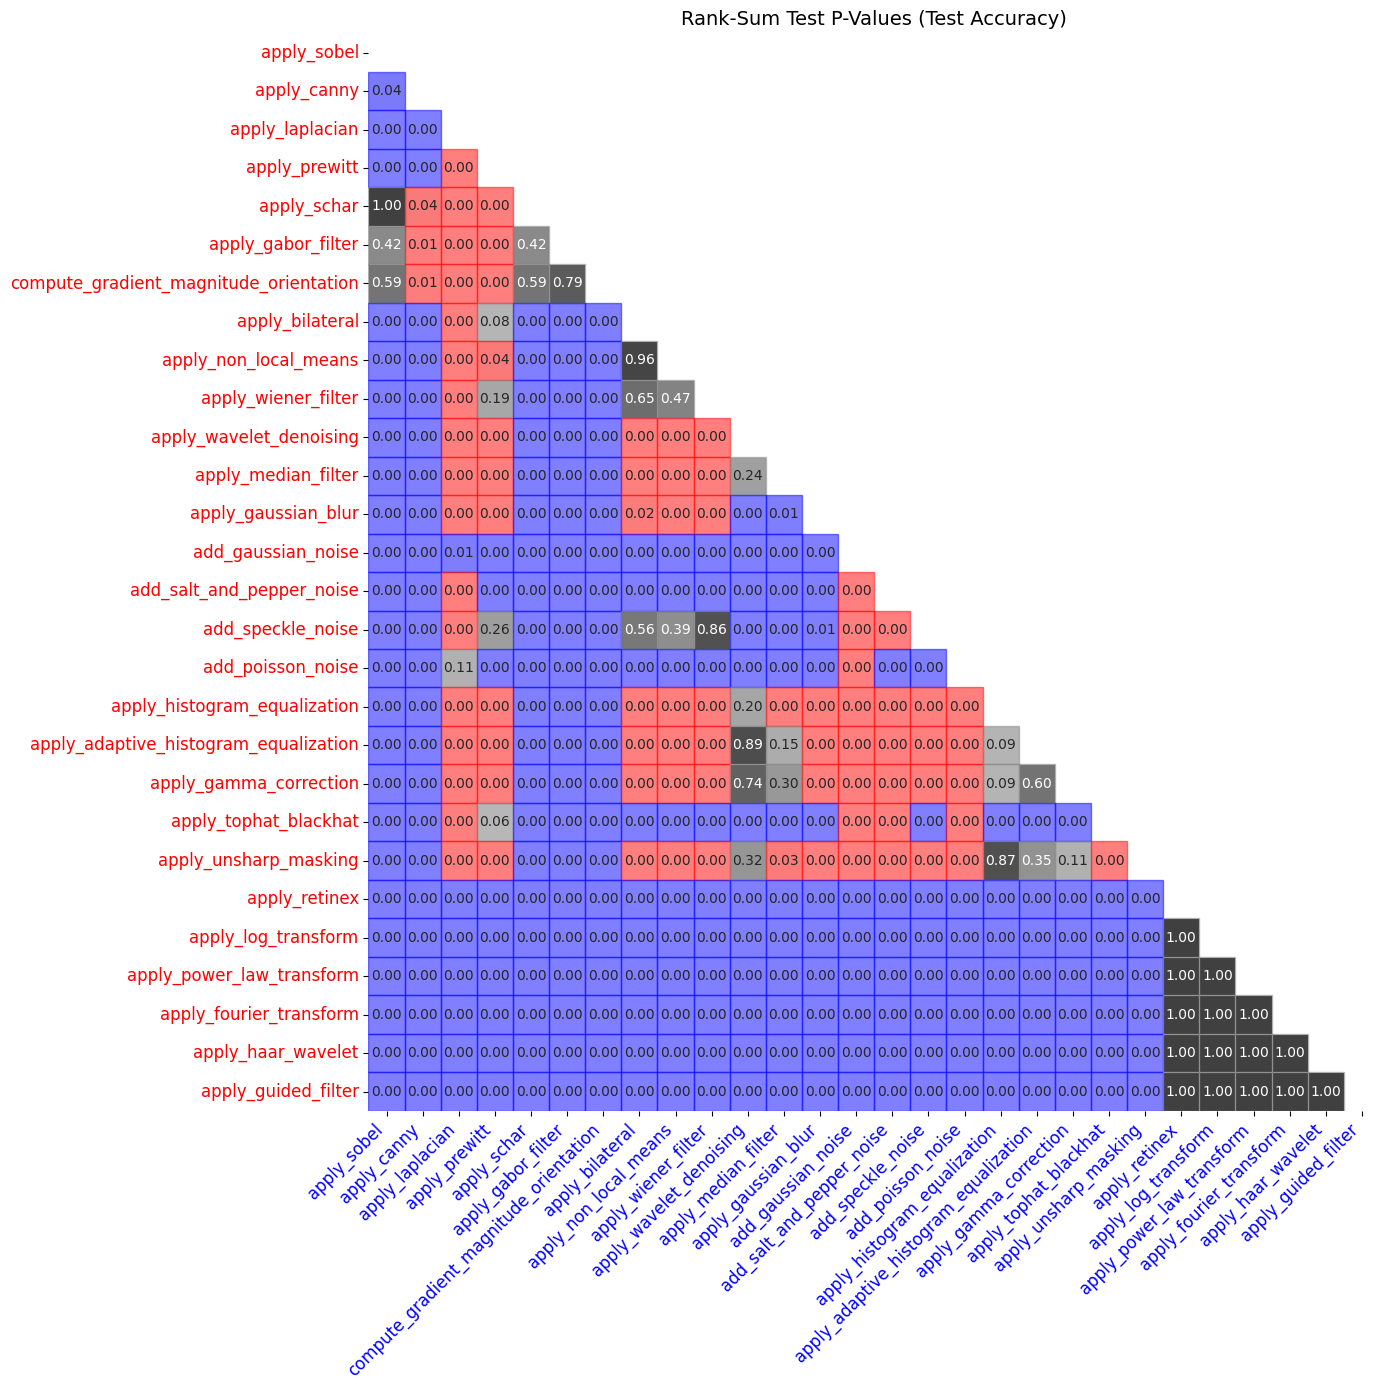

In [54]:
from scipy.stats import ranksums
metric = 'Test Accuracy'
alpha = 0.05
unique_classes = df['Class'].unique()
n_classes = len(unique_classes)
p_values = np.ones((n_classes, n_classes))  # P-value matrix
color_matrix = np.full((n_classes, n_classes), 'Gray', dtype=object)  # Initialize color matrix

for i, class1 in enumerate(unique_classes):
    for j, class2 in enumerate(unique_classes):
        if i < j:  # Avoid redundant comparisons
            data1 = df[df['Class'] == class1][metric]
            data2 = df[df['Class'] == class2][metric]

            # Rank-sum test (Mann-Whitney U test)
            stat, p_value = ranksums(data1, data2)
            p_values[j, i] = p_value  # Fill both symmetric positions
            
            # Assign colors based on significance and test direction
            if p_value < alpha:
                
                if np.median(data1) < np.median(data2):
                    color_matrix[i, j] = 'red' 
                elif np.median(data1) > np.median(data2):
                    color_matrix[i, j] = 'blue'

# Convert to DataFrame for seaborn heatmap
p_values_df = pd.DataFrame(p_values, index=unique_classes, columns=unique_classes)

# Create a heatmap with a larger figure size and no color bar
fig, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(p_values_df, annot=True, fmt=".2f", linewidths=0.5, cbar=False,  # <-- Removed color bar
            mask=np.triu(p_values), cmap="binary",
            annot_kws={"size": 10}, ax=ax)

# Manually color each square based on significance
for i in range(n_classes):
    for j in range(n_classes):
        if i < j:  # Only consider upper triangle
            ax.add_patch(plt.Rectangle((i, j), 1, 1, color=color_matrix[i, j], alpha=0.5))

# Improve label formatting
plt.xticks(rotation=45, ha='right', c="b", fontsize=12)
plt.yticks(fontsize=12, c="r")
plt.title(f'Rank-Sum Test P-Values ({metric})', fontsize=14)
plt.tight_layout()
plt.savefig(path+"/images/ranksum_filters.pdf")
plt.show()

/tmp/ipykernel_3714881/3606420411.py:70: RuntimeWarning: overflow encountered in scalar add
  michelson_original = (I_max_orig - I_min_orig) / (I_max_orig + I_min_orig + 1e-6)
/tmp/ipykernel_3714881/3606420411.py:71: RuntimeWarning: overflow encountered in scalar add
  michelson_processed = (I_max_proc - I_min_proc) / (I_max_proc + I_min_proc + 1e-6)
/its/home/drs25/.local/lib/python3.10/site-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


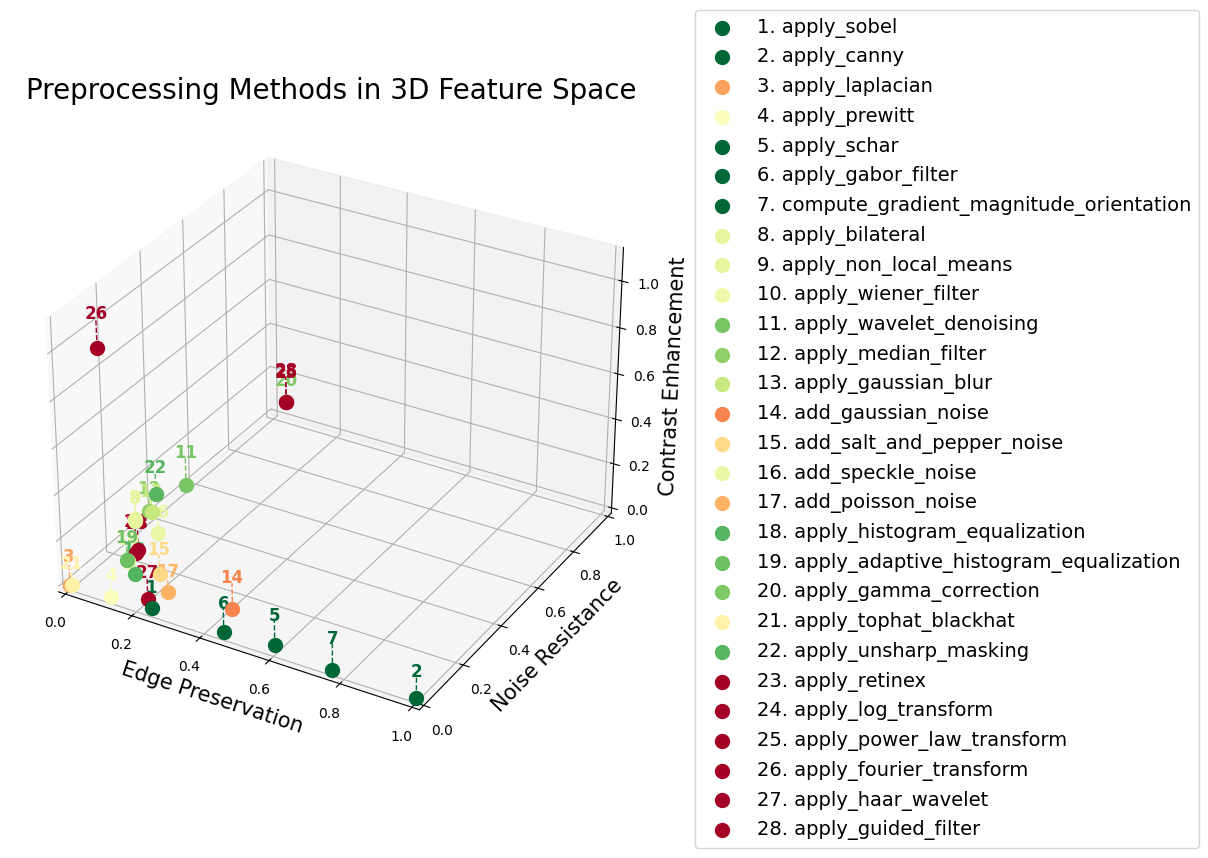

In [82]:

def plot_3D_results(results,lavels,summary):
    """Plots multiple preprocessing methods in 3D space with numbered labels in the legend and on the plot."""
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')

    class_names = list(summary['Test Accuracy']['mean'].keys())
    accuracies = np.array(list(summary['Test Accuracy']['mean']))
    # Normalize accuracies between 0 and 1
    min_acc, max_acc = accuracies.min(), accuracies.max()
    norm_accuracies = (accuracies - min_acc) / (max_acc - min_acc)

    # Choose a colormap (e.g., 'RdYlGn' for Red-Yellow-Green gradient)
    cmap = plt.cm.RdYlGn
    colours = [cmap(val) for val in norm_accuracies]

    # Create a class-to-color mapping
    class_colour_map = dict(zip(class_names, colours))
    # Assign numbers to each method
    numbered_labels = {method: i + 1 for i, method in enumerate(labels)}

    # Plot points first
    scatter_points = []
    for (method, coords) in zip(labels,results):
        number = numbered_labels[method]  # Get the assigned number
        colour=class_colour_map[method]
        scatter = ax.scatter(*coords, label=f"{number}. {method}", s=100, color=colour)
        scatter_points.append(scatter)  # Store scatter points

    # Plot numbers AFTER all points (ensuring they are on top) with connecting lines
    for (method, coords) in zip(labels,results):
        number = numbered_labels[method]
        colour=class_colour_map[method]
        # Alternate text placement for clarity
        text_offset = np.random.default_rng().uniform(np.std(results)/4,np.std(results)/2) #if number % 2 == 0 else -0.6
        text_coords = (coords[0], coords[1], coords[2]+text_offset )

        # Draw a line from the point to the text
        ax.plot([coords[0], text_coords[0]], 
                [coords[1], text_coords[1]], 
                [coords[2], text_coords[2]], 
                color=colour, linestyle="dashed", linewidth=1)

        # Add the text label
        
        ax.text(*text_coords, str(number), 
                fontsize=12, ha='center', color=colour, fontweight='bold')

    # Label axes
    ax.set_xlabel("Edge Preservation",fontsize=15)
    ax.set_ylabel("Noise Resistance",fontsize=15)
    ax.set_zlabel("Contrast Enhancement",fontsize=15)
    ax.set_title("Preprocessing Methods in 3D Feature Space",fontsize=20)

    # Move the legend to the right of the figure
    ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.5),fontsize=14)
    plt.subplots_adjust(wspace=0, hspace=0)  # No gaps between subplots
    plt.margins(0)  # Remove margins
    plt.tight_layout(pad=0)  # No padding around figure
    plt.savefig(path+"/images/3d-filters-accuracy.pdf")
    plt.show()
processed=[]
labels=[]
for i,res in enumerate(results):
    val=compute_3D_representation(example_image.astype(np.uint8),res.astype(np.uint8))
    labels.append(names[i])
    processed.append(val)

#normalize
processed=np.array(processed)

processed[:,0]=(processed[:,0]-np.min(processed[:,0]))/(np.max(processed[:,0])-np.min(processed[:,0]))
processed[:,1]=(processed[:,1]-np.min(processed[:,1]))/(np.max(processed[:,1])-np.min(processed[:,1]))
processed[:,2]=(processed[:,2]-np.min(processed[:,2]))/(np.max(processed[:,2])-np.min(processed[:,2]))

plot_3D_results(processed,labels,summary)

## look at computational costs of each

In [94]:
#look at average time to convert each dataset over 20 trials#
import time
timings=np.zeros((20,len(functions)))
for i in range(20):
    for j in range(len(functions)):
        clear_output(wait=True)
        filter=functions[j]
        start=time.time()
        dataset=apply_to_dataset(filter)
        dataset.shuffle()
        end=time.time()
        timings[i][j]=end-start
    np.save(path+"/data/compEfficiency",timings)


Dataset size: 3000 
Window size: 20 
Image: (110, 120)
Memory needed: 0.74 GB
